In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
most_recent_date = (
    session
    .query(Measurement.date)
    .order_by(Measurement.date.desc())
    .first()
)

print(most_recent_date[0])

2017-08-23


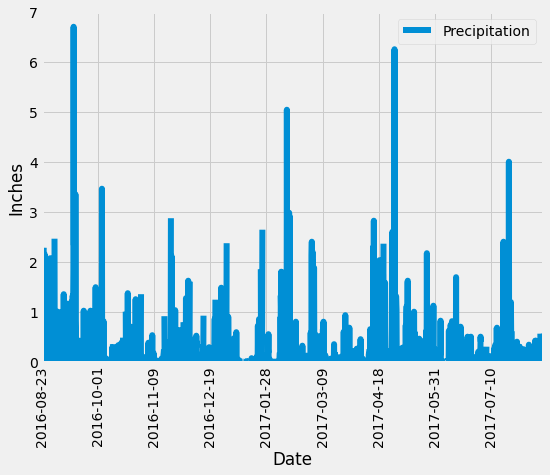

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# last date from string to date
last_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

# difference of 12 months
delta = dt.timedelta(366)

#last date - 12 month difference
first_date = last_date - delta



# Perform a query to retrieve the data and precipitation scores
last_year_precip = (
    session
    .query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= first_date)
    .all()
)    
last_year_precip

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_year_precip, columns=['Date', 'Precipitation'])


#convert date column into Date Time Column
#df['Date'] = pd.to_datetime(df['Date'])


#set the Date as index
df = df.set_index('Date')


# Sort the dataframe by date
df = df.sort_index()


#Use Pandas Plotting with Matplotlib to plot the data
df.plot(y="Precipitation", rot=90, figsize=(8,6), xticks=range(0,2230, 250), lw="6")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.ylim(0,7)
plt.xlim(0, 2230)
plt.savefig("Plots/precipitation.png")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(df.describe())

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
total_stations = (
    session
    .query(func.count(Station.id))
    .all()
)    
print(total_stations[0][0])

9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = (
    session
    .query(Station.id, Station.station, func.count(Measurement.tobs))
    .filter(Measurement.station==Station.station)
    .group_by(Station.station)
    .order_by(func.count(Measurement.tobs).desc())
    .all()
)   

most_active

[(7, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2, 'USC00513117', 2709),
 (6, 'USC00519523', 2669),
 (9, 'USC00516128', 2612),
 (3, 'USC00514830', 2202),
 (8, 'USC00511918', 1979),
 (4, 'USC00517948', 1372),
 (5, 'USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
print(f"the most active station ID is {most_active[0][0]}")


highest_temp = (
    session
    .query(func.max(Measurement.tobs))
    .filter(Measurement.station==Station.station)
    .filter(Station.id == 7)
    .first()
)
print(f"The highest temp is {highest_temp[0]}")


lowest_temp = (
    session
    .query(func.min(Measurement.tobs))
    .filter(Measurement.station==Station.station)
    .filter(Station.id == 7)
    .first()
)
print(f"The lowest temp is {lowest_temp[0]}")

avg_temp = (
    session
    .query(func.avg(Measurement.tobs))
    .filter(Measurement.station==Station.station)
    .filter(Station.id == 7)
    .first()
)
average_temp=round(avg_temp[0],2)
print(f"The average temp is {average_temp}")

the most active station ID is 7
The highest temp is 85.0
The lowest temp is 54.0
The average temp is 71.66


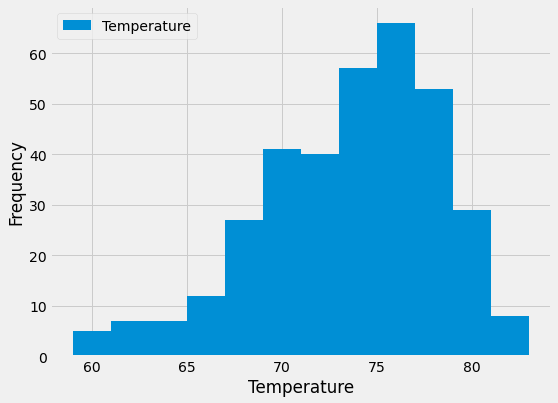

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp = (
    session
    .query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == Station.station)
    .filter(Station.id == 7)
    .filter(Measurement.date >= first_date)
    .all()
)    
last_year_temp

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(last_year_temp, columns=['Date', 'Temperature'])

temp_df.plot.hist(bins=12, figsize=(8,6))
plt.xlabel("Temperature")
plt.savefig("Plots/temp_histogram.png")
plt.show()

# Close session

In [19]:
# Close Session
session.close()